In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, Multiply, Input
from keras.models import Model
from keras.optimizers import Adam



In [20]:
import tensorflow as tf
print(tf.__version__)


2.16.2


In [26]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 16
dropout = 0.01
epoch=60
#读取数据
df1 = pd.read_excel('D:\\merged_output.xlsx')
#df1=df1.iloc[:,2:] 
df1.tail()

,0.342420,0.316625,0.290347,0.273986,0.272752,0.289864,0.308849,0.324115,0.346336,0.357423,...,0.363766,0.371063,0.376542,0.381839,0.386794,0.383438,0.384783,0.384189,0.382555,6.953933
274,0.433461,0.402856,0.381406,0.375895,0.385752,0.412182,0.430033,0.437827,0.447745,0.453083,...,0.459140,0.467921,0.474315,0.480313,0.485094,0.480621,0.482433,0.482368,0.480985,3.273756
275,0.434980,0.403904,0.381912,0.376147,0.386819,0.415208,0.433868,0.443135,0.453978,0.459478,...,0.463429,0.471867,0.478308,0.483899,0.488524,0.483526,0.484783,0.484552,0.483152,3.260194
276,0.405303,0.375872,0.352539,0.343411,0.350037,0.374317,0.392863,0.401946,0.414079,0.420124,...,0.427572,0.435774,0.441642,0.447477,0.452040,0.447834,0.449284,0.449401,0.448124,2.905737
277,0.387226,0.358824,0.335553,0.325727,0.331143,0.353771,0.371129,0.378691,0.390897,0.396978,...,0.406126,0.414248,0.420250,0.425807,0.430321,0.426749,0.428647,0.428787,0.427817,2.905737
278,0.439254,0.406130,0.379936,0.369827,0.377637,0.405595,0.426646,0.436677,0.450052,0.457096,...,0.465571,0.474036,0.480601,0.487038,0.492312,0.487462,0.489093,0.488860,0.487465,2.921562


In [31]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
input_size=len(df.iloc[1,:])
print(input_size)

26


In [40]:
# 构建 LSTM 输入
stock = df.iloc[:, :25]  # 前25个特征作为输入变���
y = df.iloc[:, 25].values  # 第26列作为响应变量

seq_len = window
amount_of_features = stock.shape[1]  # 输入特征数量
data = stock.to_numpy()  # 转换为 NumPy 数组
sequence_length = seq_len + 1  # 序列长度
result = []

for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
result = np.array(result)

# 划分训练集和测试集
row = round(0.6 * result.shape[0])  # 60% 用于训练，40% 用于测试
train = result[:int(row), :]
x_train = train[:, :-1]  # 训练集特征
x_test = result[int(row):, :-1]  # 测试集特征

# 处理响应变量
y_train = y[seq_len: seq_len + len(x_train)]
y_test = y[seq_len + len(x_train): seq_len + len(x_train) + len(x_test)]

# 重新 reshape 数据为 LSTM 输入形式
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(164, 5, 25) (164,) (109, 5, 25) (109,)


In [41]:
#建立LSTM模型

inputs=Input(shape=(window, input_size))
model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
model=MaxPooling1D(pool_size = window)(model)#池化层
model=Dropout(dropout)(model)#droupout层
model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)#双向LSTM层
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 5, 26)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 16)     │        432 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 16)     │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 16)     │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 32)        │      4,224 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 32)        │      1,056 │ bilstm[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 32)        │          0 │ bilstm[0][0],     │
│ (Multiply)          │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ multiply_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,745 (22.44 KB)

 Trainable params: 5,745 (22.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(X_train, y_train, epochs=epoch, batch_size = 256,shuffle=False,validation_data=(X_test, y_test)) #训练模型epoch次

Epoch 1/60


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 5, 26), found shape=(None, 5, 25)

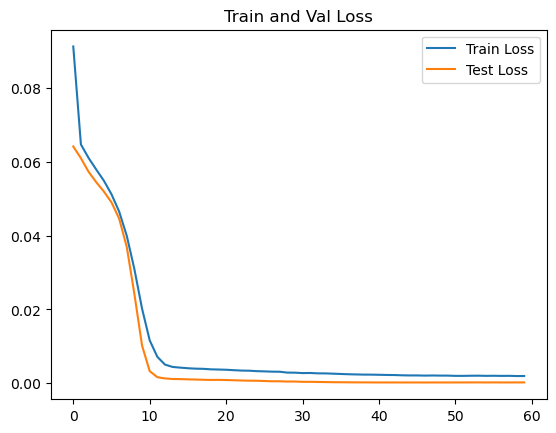

In [14]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Text(0.5, 1.0, 'Train Data')

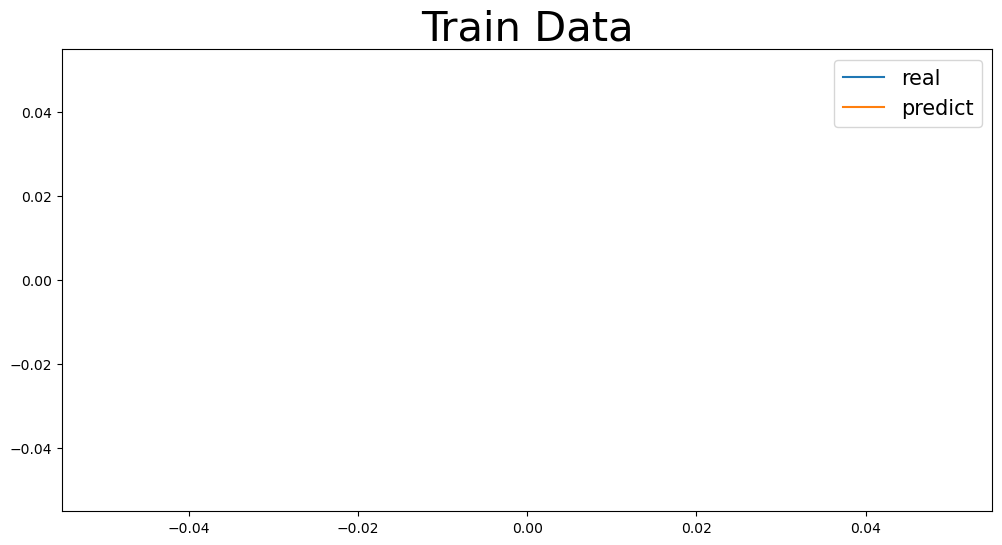

In [36]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0.5, 1.0, 'Test Data')

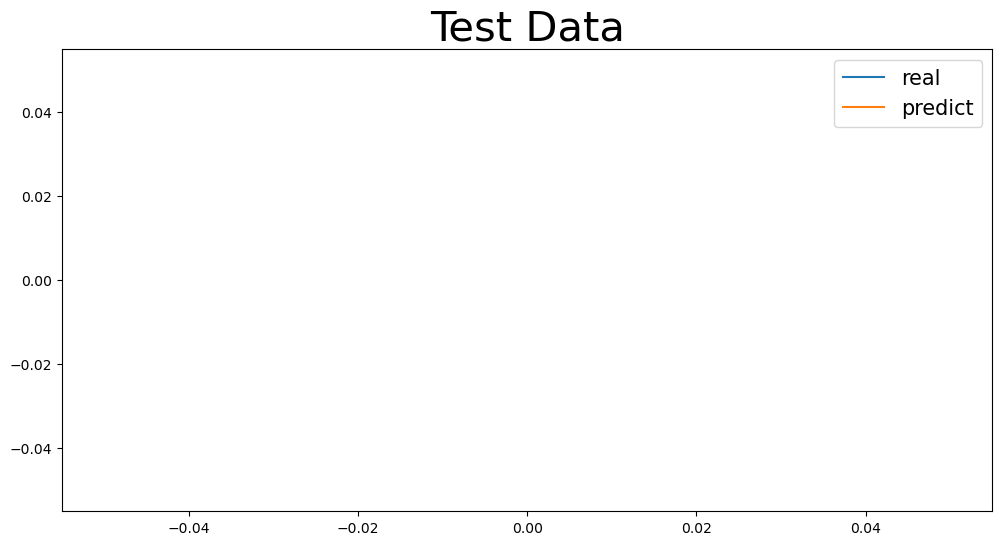

In [37]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [38]:
#输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))
print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.1875143470269349
0.053497789027790385
39.10635401990312
0.37423312883435583
测试集上的MAE/MSE/MAPE/涨跌准确率
0.2968577728880743
0.09349369731085963
62.206324518322596
0.4166666666666667


In [39]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
# 训练集 R² 和 Pearson 相关系数
r2_train = r2_score(y_train, y_train_predict)
pearson_train, _ = pearsonr(y_train, y_train_predict)

# 测试集 R² 和 Pearson 相关系数
r2_test = r2_score(y_test, y_test_predict)
pearson_test, _ = pearsonr(y_test, y_test_predict)

# 输出结果
print(f"训练集上的 R²: {r2_train:.4f}")
print(f"训练集上的 Pearson 相关系数: {pearson_train:.4f}")
print(f"测试集上的 R²: {r2_test:.4f}")
print(f"测试集上的 Pearson 相关系数: {pearson_test:.4f}")
import numpy as np

# 计算训练集 RMSEC
rmsec = np.sqrt(np.mean((y_train - y_train_predict) ** 2))

# 计算测试集 RMSEP
rmsep = np.sqrt(np.mean((y_test - y_test_predict) ** 2))

# 输出结果
print(f"训练集上的 RMSEC: {rmsec:.4f}")
print(f"测试集上的 RMSEP: {rmsep:.4f}")
# 对 R² 开根号
r2_train_sqrt = np.sqrt(r2_train)
r2_test_sqrt = np.sqrt(r2_test)

# 输出结果
print(f"训练集上的 R² 开根号: {r2_train_sqrt:.4f}")
print(f"测试集上的 R² 开根号: {r2_test_sqrt:.4f}")

训练集上的 R²: -0.0093
训练集上的 Pearson 相关系数: -0.0187
测试集上的 R²: -17.8708
测试集上的 Pearson 相关系数: -0.2168
训练集上的 RMSEC: 0.2313
测试集上的 RMSEP: 0.3058
训练集上的 R² 开根号: nan
测试集上的 R² 开根号: nan


C:\Users\79365\AppData\Local\Temp\ipykernel_62952\1931018968.py:28: RuntimeWarning: invalid value encountered in sqrt
  r2_train_sqrt = np.sqrt(r2_train)
C:\Users\79365\AppData\Local\Temp\ipykernel_62952\1931018968.py:29: RuntimeWarning: invalid value encountered in sqrt
  r2_test_sqrt = np.sqrt(r2_test)
